# Testing Deep Deterministic Policy Gradient

In [19]:
import time
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

from api.definer.core import *
from api.definer.ddpg import *
from api.definer.data import graph

import warnings
warnings.simplefilter("ignore")
mpl.style.use('default')

In [38]:
LIVE = False
SAVE = True
AROUND = True

## Collect Historical Data in USDC-ETH 0.05% Uniswap V3 pool

In [3]:
# USDC-ETH 0.05% Uniswap V3 pool on Ethereum chain
if LIVE:
    address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
    after = '2022-01-01'
    dpd = graph(address, int(datetime.timestamp(datetime.strptime(after, "%Y-%m-%d"))))
    # dpd.to_csv('./data/uniswap_v3_usdc_eth.csv')
else:
    dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])

In [4]:
decimal0 = dpd.iloc[0]['pool.token0.decimals']
decimal1 = dpd.iloc[0]['pool.token1.decimals']
decimal = decimal1 - decimal0
dpd['fg0'] = ((dpd['feeGrowthGlobal0X128']) / (2 ** 128)) / (10 ** decimal0)
dpd['fg1'] = ((dpd['feeGrowthGlobal1X128']) / (2 ** 128)) / (10 ** decimal1)
dpd['fg0shift'] = dpd['fg0'].shift(-1)
dpd['fg1shift'] = dpd['fg1'].shift(-1)
dpd['fee0token'] = dpd['fg0'] - dpd['fg0shift']
dpd['fee1token'] = dpd['fg1'] - dpd['fg1shift']
print('starting price:', dpd['close'].iloc[-1])

starting price: 1995.8472015960615


In [5]:
n = 1
mini = 1500
maxi = 2500
target = dpd['close'].iloc[-1] * n
base = 0

In [6]:
SMIN, SMAX = np.sqrt(mini * 10 ** decimal), np.sqrt(maxi * 10 ** decimal)
amount0, amount1, deltaL = get_initial_wealth(base, dpd, decimal, SMIN, SMAX, target)
liq = get_liquidity(dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
dpd_step = get_fee(dpd, base, mini, maxi, liq, decimal0, decimal1, decimal)

In [8]:
p_mean = dpd.iloc[-1].close
p_std = dpd.close.std()
v_mean = dpd.iloc[-1].amountV
v_std = dpd.amountV.std()

## Load Trained DDPG Model

In [10]:
EPISODES = 2
EP_STEPS = 1000 - 2
MEMORY_CAPACITY = 500

s_dim = 2
a_dim = 2
a_high_bound = 10
a_low_bound = -10

ddpg = DDPG(a_dim, s_dim, a_high_bound)

ddpg.actor_eval.load_state_dict(torch.load('./results/ddpg_actor_eval.pt'))
ddpg.actor_target.load_state_dict(torch.load('./results/ddpg_actor_target.pt'))
ddpg.critic_eval.load_state_dict(torch.load('./results/ddpg_critic_eval.pt'))
ddpg.critic_target.load_state_dict(torch.load('./results/ddpg_critic_target.pt'))

<All keys matched successfully>

In [11]:
a_list = []

s = np.array([
    (dpd.iloc[-1].close - p_mean) / p_std,
    (dpd.iloc[-1].amountV - v_mean) / v_std
])

ep_r = 0
r = 0

pbar = tqdm(range(EP_STEPS - 2))
for j in pbar:
    
    step_dict = {}
    
    pbar.set_description("step reward: {} \t".format(round(r, 3)))
    
    dpd_step = dpd.iloc[:-(j + 1)]
    target = dpd_step['close'].iloc[-1] * n
    
    p_mean = dpd_step.iloc[-1].close
    v_mean = dpd_step.iloc[-1].amountV
    
    a = ddpg.choose_action(s)
    a = np.clip(np.random.normal(a, 0), a_low_bound, a_high_bound)
    (a[0], a[1]) = (a[1], a[0]) if a[0] > a[1] else (a[0], a[1])
    if a[0] == a[1]: a[1] += 0.000001

    action = a * p_std + p_mean
    mini, maxi = action[0], action[1]
    SMIN, SMAX = np.sqrt(mini * 10 ** decimal), np.sqrt(maxi * 10 ** decimal)
    
    step_dict['mini'] = action[0]
    step_dict['maxi'] = action[1]
    step_dict['price'] = dpd_step['close'].iloc[-1]
    
    amount0, amount1, deltaL = get_initial_wealth(base, dpd_step, decimal, SMIN, SMAX, target)
    liq = get_liquidity(dpd_step['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
    dpd_step = get_fee(dpd_step, base, mini, maxi, liq, decimal0, decimal1, decimal)
    
    state_next = dpd_step.iloc[-2]
    s_ = np.array([
        (state_next.close - p_mean) / p_std,
        (state_next.amountV - v_mean) / v_std
    ])
    r = state_next.feeusd
        
    s = s_
    ep_r += r
    
    step_dict['feeusd'] = r
    
    a_list.append(step_dict)

step reward: 3.608 	: 100%|██████████| 996/996 [09:04<00:00,  1.83it/s] 


In [15]:
pd.DataFrame(a_list).to_csv('./results/ddpg_actions.csv')

## Visualization

In [16]:
df = pd.read_csv('./results/ddpg_actions.csv', index_col=[0])
df

,mini,maxi,price,feeusd
0,1944.409973,2139.456963,2014.490845,0.083378
1,1956.162523,2134.499370,2021.155534,0.114378
2,1964.350345,2137.865639,2027.494168,0.191237
3,1972.715640,2141.162022,2033.964624,0.078150
4,1965.886007,2137.309243,2027.757645,0.113699
...,...,...,...,...
991,2191.793176,2214.114181,2197.464306,1.203074
992,2191.271941,2211.794481,2196.153364,2.357695
993,2209.103930,2227.108559,2213.155051,2.667964
994,2228.792814,2229.242516,2225.786265,3.607899


In [17]:
dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])
dpd['datetime'] = pd.to_datetime(dpd['periodStartUnix'], unit='s')
dpd.sort_values('datetime').iloc[1:-3]

,periodStartUnix,liquidity,high,low,close,feeGrowthGlobal0X128,feeGrowthGlobal1X128,pool.totalValueLockedUSD,pool.totalValueLockedToken1,pool.totalValueLockedToken0,pool.token0.decimals,pool.token1.decimals,datetime
998,1.701119e+09,2.582512e+19,2017.917074,1995.832184,2014.490845,2.500188e+33,1.213144e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 21:00:00
997,1.701122e+09,2.569357e+19,2021.157388,2013.370696,2021.155534,2.500210e+33,1.213149e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 22:00:00
996,1.701126e+09,2.584512e+19,2028.429981,2021.134907,2027.494168,2.500234e+33,1.213155e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 23:00:00
995,1.701130e+09,2.279386e+19,2038.939967,2024.358686,2033.964624,2.500271e+33,1.213167e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-28 00:00:00
994,1.701133e+09,2.588521e+19,2033.957109,2025.841723,2027.757645,2.500277e+33,1.213176e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-28 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1.704686e+09,1.595604e+19,2198.516132,2190.047997,2197.464306,2.555067e+33,1.237331e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 04:00:00
6,1.704690e+09,1.101780e+19,2197.805651,2190.657194,2196.153364,2.555092e+33,1.237343e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 05:00:00
5,1.704694e+09,1.020713e+19,2222.846865,2196.065101,2213.155051,2.555175e+33,1.237367e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 06:00:00
4,1.704697e+09,1.030165e+19,2230.691581,2213.177931,2225.786265,2.555236e+33,1.237384e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 07:00:00


In [18]:
df = pd.concat([df, dpd.sort_values('datetime').iloc[1:-3].reset_index(drop=True)], axis=1)
df

,mini,maxi,price,feeusd,periodStartUnix,liquidity,high,low,close,feeGrowthGlobal0X128,feeGrowthGlobal1X128,pool.totalValueLockedUSD,pool.totalValueLockedToken1,pool.totalValueLockedToken0,pool.token0.decimals,pool.token1.decimals,datetime
0,1944.409973,2139.456963,2014.490845,0.083378,1.701119e+09,2.582512e+19,2017.917074,1995.832184,2014.490845,2.500188e+33,1.213144e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 21:00:00
1,1956.162523,2134.499370,2021.155534,0.114378,1.701122e+09,2.569357e+19,2021.157388,2013.370696,2021.155534,2.500210e+33,1.213149e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 22:00:00
2,1964.350345,2137.865639,2027.494168,0.191237,1.701126e+09,2.584512e+19,2028.429981,2021.134907,2027.494168,2.500234e+33,1.213155e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 23:00:00
3,1972.715640,2141.162022,2033.964624,0.078150,1.701130e+09,2.279386e+19,2038.939967,2024.358686,2033.964624,2.500271e+33,1.213167e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-28 00:00:00
4,1965.886007,2137.309243,2027.757645,0.113699,1.701133e+09,2.588521e+19,2033.957109,2025.841723,2027.757645,2.500277e+33,1.213176e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-28 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2191.793176,2214.114181,2197.464306,1.203074,1.704686e+09,1.595604e+19,2198.516132,2190.047997,2197.464306,2.555067e+33,1.237331e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 04:00:00
992,2191.271941,2211.794481,2196.153364,2.357695,1.704690e+09,1.101780e+19,2197.805651,2190.657194,2196.153364,2.555092e+33,1.237343e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 05:00:00
993,2209.103930,2227.108559,2213.155051,2.667964,1.704694e+09,1.020713e+19,2222.846865,2196.065101,2213.155051,2.555175e+33,1.237367e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 06:00:00
994,2228.792814,2229.242516,2225.786265,3.607899,1.704697e+09,1.030165e+19,2230.691581,2213.177931,2225.786265,2.555236e+33,1.237384e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2024-01-08 07:00:00


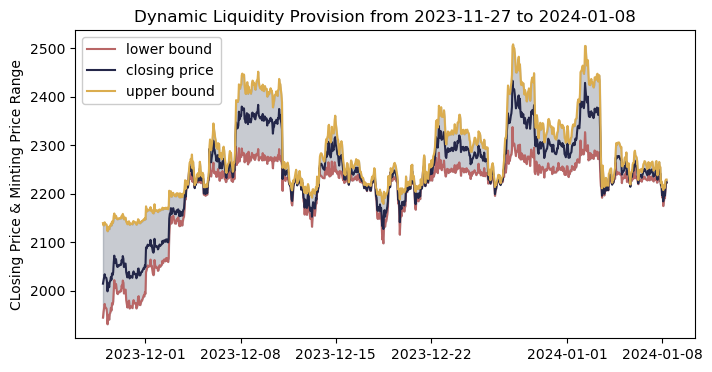

In [42]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=df.datetime, y=df.mini, label='lower bound', color='#B96666')
sns.lineplot(x=df.datetime, y=df.price, label='closing price', color='#242749', linestyle='-')
sns.lineplot(x=df.datetime, y=df.maxi, label='upper bound', color='#DBAD4F')
ax.fill_between(df.datetime, list(df.mini), list(df.maxi), color='#4B5569', alpha=0.3)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Dynamic Liquidity Provision from {} to {}'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d')))
plt.ylabel('CLosing Price & Minting Price Range')
plt.xlabel(None)
legend = plt.legend()
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
if SAVE:
    plt.savefig('./img/dynamic_minting_hourly.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [41]:
print('Total fee earnings estimated with dynamic minting using DDPG:', round(df.feeusd.sum(), 2))

Total fee earnings estimated with dynamic minting using DDPG: 1388.26
